# Notes

This notebook attempts to plot the baryonic mass fraction of halos, filaments and voids in the IllustrisTNG simulation in the style of Figure 2 from Martizzi+19 (https://arxiv.org/abs/1810.01883) and Figure A.1 from Artale+21 (https://arxiv.org/abs/2102.01092)

Code is adapted from Plot_evolving_density_structures.ipynb

# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import yt
import trident
from trident import LightRay
import illustris_python as il
from astropy import units as u
from astropy import constants as c
from yt.utilities.cosmology import Cosmology
from matplotlib import pyplot as plt


/draco/u/cwalker/virtual_environments/yt-git/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /u/cwalker/.config/yt/ytrc is deprecated in favor of /u/cwalker/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0 . This feature will be removed in v4.1.0
  from yt.config import ytcfg


# Choose snapshots and chunks to plot for

In [9]:
snapshots = [99,91,84,78,72,67,59,50,40,33,25,21,17]#,13,11,8,6,4,3,2]
chunks = [0,1,2,3,4,5,6] #each TNG100-3 snapshot has chunks running from 0 to 6 inclusive

# Begin

In [ ]:
######################################
#initialise arrays that hold all data#
######################################

#redshift array
allsnaps_redshifts=[]

#baryon arrays
#PartType0 (gas)
allsnaps_tot_PT0_arr = []
allsnaps_hal_PT0_arr = []
allsnaps_fil_PT0_arr = []
allsnaps_voi_PT0_arr = []
#PartType4 (stars)
allsnaps_tot_PT4_arr = []
allsnaps_hal_PT4_arr = []
allsnaps_fil_PT4_arr = []
allsnaps_voi_PT4_arr = []

#check arrays
allsnaps_dens_crit_array = []
allsnaps_m_p_array = []

################################
#loop over snapshots and chunks#
################################

for i in range(len(snapshots)):
    
    ######################################################
    #initialise arrays that hold individual snapshot data#
    ######################################################

    #redshift array
    redshifts=[]

    #baryon arrays
    #PartType0 (gas)
    tot_PT0_arr = []
    hal_PT0_arr = []
    fil_PT0_arr = []
    voi_PT0_arr = []
    #PartType4 (stars)
    tot_PT4_arr = []
    hal_PT4_arr = []
    fil_PT4_arr = []
    voi_PT4_arr = []

    #check arrays
    dens_crit_array = []
    m_p_array = []
    
    for j in range(len(chunks)):
    
        ###########################
        #select snapshot and chunk#
        ###########################

        snapshot = snapshots[i]
        chunk = chunks[j]
        print('processsing snapshot {0:02d}, chunk {1}'.format(snapshot,chunk))

        ######################
        #load snapshot header#
        ######################

        print('loading snapshot header')
        basepath = '/virgo/simulations/IllustrisTNG/TNG100-3/output/'
        header=il.groupcat.loadHeader(basepath,snapshot)
        print('header loaded.')

        ########################################################
        #extract redshift from header, append to redshift array#
        ########################################################

        redshifts.append(header['Redshift'])

        #####################
        #load Illustris data#
        #####################

        data='/virgo/simulations/IllustrisTNG/TNG100-3/output/snapdir_0{0:02d}/snap_0{0:02d}.{1}.hdf5'.format(snapshot,chunk)
        print('loading dataset: {0}'.format(data))
        ds=yt.load(data)
        print('data loaded.')

        ####################################
        #define proton mass in solar masses#
        ####################################

        print('calculating proton mass:')
        m_p = ds.quan((c.m_p).to(u.solMass).value,'Msun')
        print ('proton mass: {0}'.format(m_p))
        m_p_array.append(m_p)

        ds.index

        ############################################
        #calculate critical density of the Universe#
        ############################################

        print('Calculating critical density of the Universe')
        co=Cosmology()
        grav=ds.quan(6.6743e-11,'m**3/(kg*s**2)')
        H=co.hubble_parameter(0).in_units('km/s/Mpc')
        print('grav={0}'.format(grav))
        print('H0 = {0}'.format(H))
        dens_crit = ((3 * H**2)/(8*np.pi* grav))#.in_units('h**2/(code_length**3/(Msun*s**2))')
        print ('critical density is: {0}'.format(dens_crit))
        print('critical density in kg/m^3: {0}'.format(dens_crit.in_units('kg/m**3')))
        dens_crit_array.append(dens_crit)

        ad = ds.all_data()

        ##########################################################
        #convert dark matter density to units of critical density#
        ##########################################################

        #PartType0 (gas)
        dark_units_PT0 = ad['PartType0','SubfindDMDensity']*ds.quan(1e10,"(Msun/h)/((code_length)**3)")/dens_crit
        #PartType4 (stars)
        dark_units_PT4 = ad['PartType4','SubfindDMDensity']*ds.quan(1e10,"(Msun/h)/((code_length)**3)")/dens_crit

        ###############################################################
        #create Large-Scale Structure (LSS) masks for each matter type#
        ###############################################################

        #PartType0 (gas)
        voi_mask_PT0 = dark_units_PT0 < 0.1
        fil_mask_PT0 = np.logical_and(dark_units_PT0 >= 0.01, dark_units_PT0 < 57)
        hal_mask_PT0 = dark_units_PT0 >= 57 
        #PartType4 (stars)
        voi_mask_PT4 = dark_units_PT4 < 0.1
        fil_mask_PT4 = np.logical_and(dark_units_PT4 >= 0.01, dark_units_PT4 < 57)
        hal_mask_PT4 = dark_units_PT4 >= 57

        ##########################################################
        #calculate mass in each LSS for each baryonic matter type#
        ##########################################################

        #PartType0 (gas)
        tot_PT0 = np.sum(ad['PartType0','Masses'])
        hal_PT0 = np.sum(ad['PartType0','Masses'][hal_mask_PT0])
        fil_PT0 = np.sum(ad['PartType0','Masses'][fil_mask_PT0])
        voi_PT0 = np.sum(ad['PartType0','Masses'][voi_mask_PT0])
        #PartType4 (stars)
        tot_PT4 = np.sum(ad['PartType4','Masses'])
        hal_PT4 = np.sum(ad['PartType4','Masses'][hal_mask_PT4])
        fil_PT4 = np.sum(ad['PartType4','Masses'][fil_mask_PT4])
        voi_PT4 = np.sum(ad['PartType4','Masses'][voi_mask_PT4])

        ##########################
        #append results to arrays#
        ##########################

        #PartType0 (gas)
        tot_PT0_arr.append(tot_PT0)
        hal_PT0_arr.append(hal_PT0)
        fil_PT0_arr.append(fil_PT0) 
        voi_PT0_arr.append(voi_PT0) 
        #PartType4 (gas)
        tot_PT4_arr.append(tot_PT4)
        hal_PT4_arr.append(hal_PT4)
        fil_PT4_arr.append(fil_PT4) 
        voi_PT4_arr.append(voi_PT4)
        
    ######################################################    
    #append all results for a snapshot to the final array#
    ######################################################
    
    #PartType0 (gas)
    allsnaps_tot_PT0_arr.append(tot_PT0_arr)
    allsnaps_hal_PT0_arr.append(hal_PT0_arr)
    allsnaps_fil_PT0_arr.append(fil_PT0_arr) 
    allsnaps_voi_PT0_arr.append(voi_PT0_arr) 
    #PartType4 (gas)
    allsnaps_tot_PT4_arr.append(tot_PT4_arr)
    allsnaps_hal_PT4_arr.append(hal_PT4_arr)
    allsnaps_fil_PT4_arr.append(fil_PT4_arr) 
    allsnaps_voi_PT4_arr.append(voi_PT4_arr)    
    
    allsnaps_m_p_array.append(m_p_array)
    allsnaps_dens_crit_array.append(dens_crit_array)
    allsnaps_redshifts.append(redshifts)

    
    print('filled baryon arrays')
    
    
    
    

processsing snapshot 99, chunk 0
loading snapshot header
header loaded.
loading dataset: /virgo/simulations/IllustrisTNG/TNG100-3/output/snapdir_099/snap_099.0.hdf5


yt : [INFO     ] 2021-05-20 16:29:24,892 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2021-05-20 16:29:24,977 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2021-05-20 16:29:24,977 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-05-20 16:29:24,978 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-05-20 16:29:24,979 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2021-05-20 16:29:24,979 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-05-20 16:29:24,980 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2021-05-20 16:29:24,980 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2021-05-20 16:29:24,981 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2021-05-20 16:29:24,982 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-05-20 16:29:24,982 Parameters: hubble_consta

data loaded.
calculating proton mass:
proton mass: 8.411856872862986e-58 Msun


yt : [INFO     ] 2021-05-20 16:29:30,126 Allocating for 3.738e+08 particles
Initializing refined index: 100%|█████████▉| 721/722 [24:45<00:02,  2.06s/it]  


Calculating critical density of the Universe
grav=6.6743e-11 m**3/(kg*s**2)
H0 = 71.0 km/(Mpc*s)
critical density is: 9.468720094206941e-27 kg/m**3
critical density in kg/m^3: 9.468720094206941e-27 kg/m**3
processsing snapshot 99, chunk 1
loading snapshot header
header loaded.
loading dataset: /virgo/simulations/IllustrisTNG/TNG100-3/output/snapdir_099/snap_099.1.hdf5


yt : [INFO     ] 2021-05-20 16:58:19,819 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2021-05-20 16:58:19,901 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2021-05-20 16:58:19,902 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-05-20 16:58:19,902 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-05-20 16:58:19,903 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2021-05-20 16:58:19,904 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-05-20 16:58:19,904 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2021-05-20 16:58:19,905 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2021-05-20 16:58:19,905 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2021-05-20 16:58:19,906 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-05-20 16:58:19,906 Parameters: hubble_consta

data loaded.
calculating proton mass:
proton mass: 8.411856872862986e-58 Msun


yt : [INFO     ] 2021-05-20 16:58:22,500 Allocating for 3.738e+08 particles
Initializing refined index: 100%|█████████▉| 721/722 [23:08<00:01,  1.93s/it]


Calculating critical density of the Universe
grav=6.6743e-11 m**3/(kg*s**2)
H0 = 71.0 km/(Mpc*s)
critical density is: 9.468720094206941e-27 kg/m**3
critical density in kg/m^3: 9.468720094206941e-27 kg/m**3
processsing snapshot 99, chunk 2
loading snapshot header
header loaded.
loading dataset: /virgo/simulations/IllustrisTNG/TNG100-3/output/snapdir_099/snap_099.2.hdf5


yt : [INFO     ] 2021-05-20 17:25:20,495 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2021-05-20 17:25:20,561 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2021-05-20 17:25:20,562 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-05-20 17:25:20,562 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-05-20 17:25:20,563 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2021-05-20 17:25:20,564 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-05-20 17:25:20,564 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2021-05-20 17:25:20,565 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2021-05-20 17:25:20,565 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2021-05-20 17:25:20,566 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-05-20 17:25:20,566 Parameters: hubble_consta

data loaded.
calculating proton mass:
proton mass: 8.411856872862986e-58 Msun


yt : [INFO     ] 2021-05-20 17:25:23,491 Allocating for 3.738e+08 particles
Initializing refined index:  89%|████████▉ | 644/722 [18:15<15:03, 11.58s/it]

In [11]:
#########################
#convert to numpy arrays#
#########################

#tot_PT0_arr=np.array(tot_PT0_arr)
#hal_PT0_arr=np.array(hal_PT0_arr)
#fil_PT0_arr=np.array(fil_PT0_arr)
#voi_PT0_arr=np.array(voi_PT0_arr)

#tot_PT4_arr=np.array(tot_PT4_arr)
#hal_PT4_arr=np.array(hal_PT4_arr)
#fil_PT4_arr=np.array(fil_PT4_arr)
#voi_PT4_arr=np.array(voi_PT4_arr)

allsnaps_tot_PT0_arr = np.array(allsnaps_tot_PT0_arr)
allsnaps_hal_PT0_arr = np.array(allsnaps_hal_PT0_arr)
allsnaps_fil_PT0_arr = np.array(allsnaps_fil_PT0_arr)
allsnaps_voi_PT0_arr = np.array(allsnaps_voi_PT0_arr)

allsnaps_tot_PT4_arr = np.array(allsnaps_tot_PT4_arr)
allsnaps_hal_PT4_arr = np.array(allsnaps_hal_PT4_arr)
allsnaps_fil_PT4_arr = np.array(allsnaps_fil_PT4_arr)
allsnaps_voi_PT4_arr = np.array(allsnaps_voi_PT4_arr)

allsnaps_redshifts = np.array(allsnaps_redshifts)
allsnaps_m_p_array = np.array(allsnaps_m_p_array)
allsnaps_dens_crit_array = np.array(allsnaps_dens_crit_array)

In [65]:
###############
#check lengths#
###############

print(len(snapshots))
print(allsnaps_redshifts.shape)
print(allsnaps_m_p_array.shape)
print(allsnaps_dens_crit_array.shape)
print(allsnaps_hal_PT0_arr.shape)
print(allsnaps_fil_PT0_arr.shape)
print(allsnaps_voi_PT0_arr.shape)
print(allsnaps_hal_PT4_arr.shape)
print(allsnaps_fil_PT4_arr.shape)
print(allsnaps_voi_PT4_arr.shape)


print(allsnaps_tot_PT0_arr.sum(axis=1).shape) #summing chunks for each snapshot
print(allsnaps_redshifts.mean(axis=1)) #recovering the redshift for each snapshot

13
(13, 7)
(13, 7)
(13, 7)
(13, 7)
(13, 7)
(13, 7)
(13, 7)
(13, 7)
(13, 7)
(13,)
[2.22044605e-16 9.94018026e-02 1.97284182e-01 2.97717685e-01
 3.99926965e-01 5.03047523e-01 7.00106354e-01 9.97294226e-01
 1.49551217e+00 2.00202814e+00 3.00813107e+00 4.00794511e+00
 4.99593347e+00]


In [52]:
##################################################
#for each of the 13 snapshots, sum the masses in #
#each of the 7 simulation subchunks to obtain    #
#the total mass for the entire redshift          #
##################################################

tot_PT0_arr_summed = allsnaps_tot_PT0_arr.sum(axis=1)
hal_PT0_arr_summed = allsnaps_hal_PT0_arr.sum(axis=1)
fil_PT0_arr_summed = allsnaps_fil_PT0_arr.sum(axis=1)
voi_PT0_arr_summed = allsnaps_voi_PT0_arr.sum(axis=1)

tot_PT4_arr_summed = allsnaps_tot_PT4_arr.sum(axis=1)
hal_PT4_arr_summed = allsnaps_hal_PT4_arr.sum(axis=1)
fil_PT4_arr_summed = allsnaps_fil_PT4_arr.sum(axis=1)
voi_PT4_arr_summed = allsnaps_voi_PT4_arr.sum(axis=1)

print(allsnaps_hal_PT0_arr.sum(axis=1).shape)

(13,)


In [53]:
####################################################
#for each of the 13 snapshots, sum the masses in   #
#PT0 and PT4 to obtain the total baryonic mass for #
#each redshift                                     #
####################################################

tot_PT14_arr_summed = tot_PT0_arr_summed + tot_PT4_arr_summed
hal_PT14_arr_summed = hal_PT0_arr_summed + hal_PT4_arr_summed
fil_PT14_arr_summed = fil_PT0_arr_summed + fil_PT4_arr_summed
voi_PT14_arr_summed = voi_PT0_arr_summed + voi_PT4_arr_summed

print(hal_PT14_arr_summed.shape)

(13,)


In [54]:
#######################
#create mass fractions#
#######################

#hal_frac = (hal_PT0_arr + hal_PT4_arr)/(hal_PT0_arr + hal_PT4_arr + fil_PT0_arr + fil_PT4_arr + voi_PT0_arr + voi_PT4_arr)
#fil_frac = (fil_PT0_arr + fil_PT4_arr)/(hal_PT0_arr + hal_PT4_arr + fil_PT0_arr + fil_PT4_arr + voi_PT0_arr + voi_PT4_arr)
#voi_frac = (voi_PT0_arr + voi_PT4_arr)/(hal_PT0_arr + hal_PT4_arr + fil_PT0_arr + fil_PT4_arr + voi_PT0_arr + voi_PT4_arr)


hal_frac = (hal_PT14_arr_summed)/(hal_PT14_arr_summed + fil_PT14_arr_summed + voi_PT14_arr_summed)
fil_frac = (fil_PT14_arr_summed)/(hal_PT14_arr_summed + fil_PT14_arr_summed + voi_PT14_arr_summed)
voi_frac = (voi_PT14_arr_summed)/(hal_PT14_arr_summed + fil_PT14_arr_summed + voi_PT14_arr_summed)

print(hal_frac.shape)

(13,)


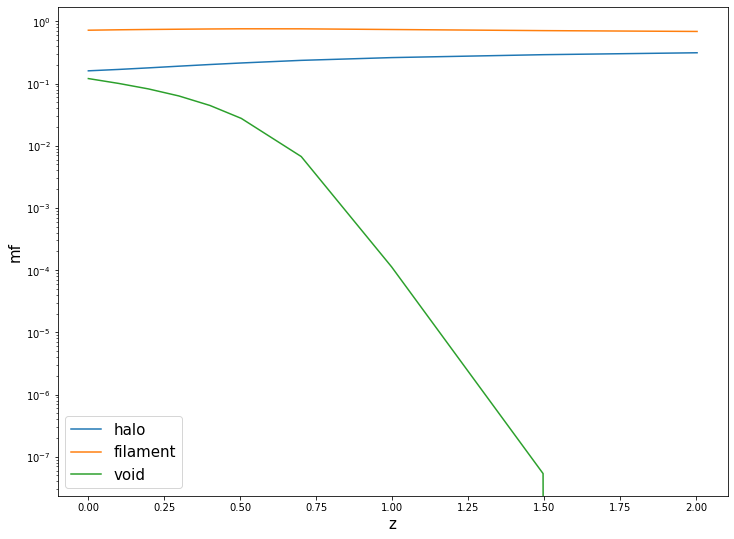

In [55]:
#####################
#plot mass fractions#
#####################

fig=plt.figure(figsize=(12,9))

ax1=fig.add_subplot(111)
ax1.set_xlabel('z',fontsize=15)
ax1.set_ylabel('mf',fontsize=15)
ax1.set_yscale('log')

ax1.plot((allsnaps_redshifts.mean(axis=1))[0:10],hal_frac[0:10],label='halo')
ax1.plot((allsnaps_redshifts.mean(axis=1))[0:10],fil_frac[0:10],label='filament')
ax1.plot((allsnaps_redshifts.mean(axis=1))[0:10],voi_frac[0:10],label='void')


plt.legend(fontsize=15)
plt.savefig('evolving_mass_fraction.png')
plt.show()